# 时间序列分析

## 1. 什么是时间序列？

时间序列是以时间戳为索引的数组，时间戳可以代表不同的时间框架，例如分钟，小时，日，季度，年等。

时间序列分析的主要目的是理解数据的内在属性，为建立预测模型奠定基础。

## 2. 导入数据

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

这里我们使用美国实际GDP数据。

In [5]:
rgdp = pd.read_csv("../quant_research/data/rgdp.csv", parse_dates=["date"], index_col="date")
rgdp.head()

,real_gdp
date,
1947-01-01,2033.1
1947-04-01,2027.6
1947-07-01,2023.5
1947-10-01,2055.1
1948-01-01,2086.0


对于经济指标，我们更关注环比增长率和同比增长率而不是原始值。

In [6]:
rgdp["pch"] = round(rgdp["real_gdp"].pct_change(1) * 100, 2)
rgdp["pc1"] = round(rgdp["real_gdp"].pct_change(4) * 100, 2)
rgdp.tail()

,real_gdp,pch,pc1
date,,,
2019-01-01,18927.3,0.77,2.65
2019-04-01,19021.9,0.50,2.28
2019-07-01,19121.1,0.52,2.07
2019-10-01,19222.0,0.53,2.33
2020-01-01,18987.9,-1.22,0.32


## 3. 数据可视化

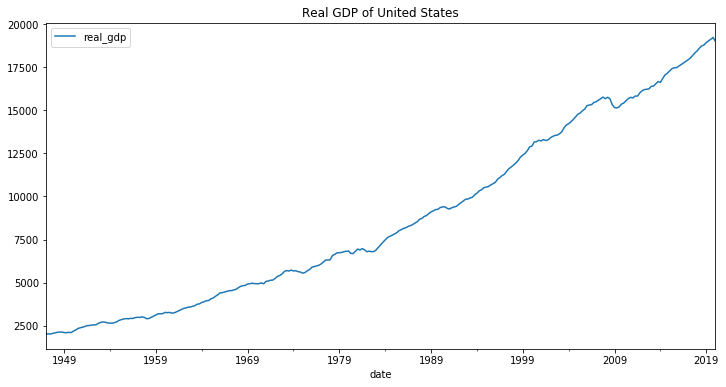

In [7]:
rgdp.plot(y="real_gdp", figsize=(12, 6), title="Real GDP of United States")

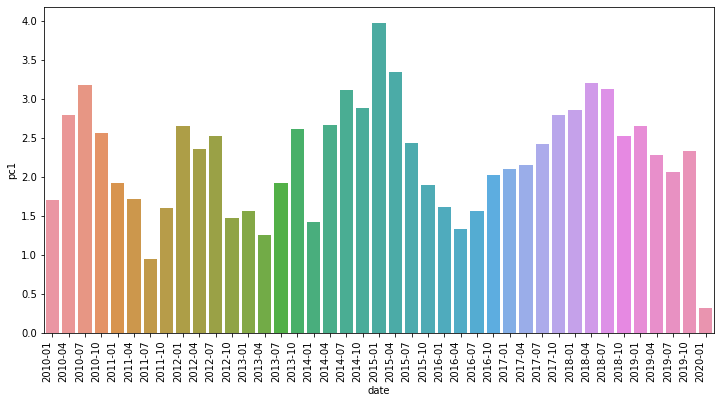

In [8]:
rgdp2 = rgdp["2010":]

fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.barplot(rgdp2.index, rgdp2.pc1, ax=ax, )

# 调整x轴标签样式
xtick_labels = rgdp2.index.strftime("%Y-%m")
labels = ax.set_xticklabels(xtick_labels, rotation=90, ha="right")

季节性图表(seasonal plot)，观察时间序列是否有明显的季节性特征。

Text(0, 0.5, 'percent change')

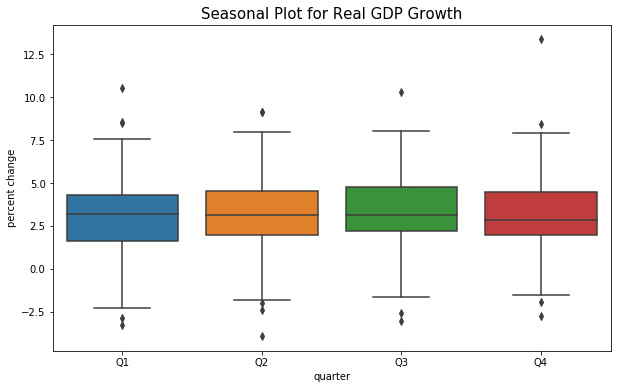

In [9]:
# 添加分类变量"季度"
rgdp["quarter"] = rgdp.index.quarter

# 箱线图，将实际GDP增长率按季度分类汇总
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot("quarter", "pc1", data=rgdp, ax=ax)

ax.set_title("Seasonal Plot for Real GDP Growth", fontsize=15)
ax.set_xticklabels(["Q1", "Q2", "Q3", "Q4"])
ax.set_ylabel("percent change")

## 4. 时间序列分解

#### 时间序列通常被分解为几个部分：

1. Level: 水平值，时间序列均值
2. Trend: 趋势，上涨/下跌部分
3. Seasonality: 季节性因素，特定时间段重复出现的模式
4. Error: 噪音项，代表随机冲击

必须指出并非所有的时间序列都同时包含4个部分，有的序列可能有趋势但没有季节性效应，有的可能包含季节性效应但没有趋势。

#### 周期性效应 vs 季节性效应

周期性效应与季节性效应是两个不同的概念，周期性(cyclic)效应是指重复性的模式，和特定的时间段无关；季节性效应是指在某个特定的时间段会出现的模式，例如沃尔玛的销售额在圣诞节期间会大幅增长，城市用电量在夏季会大幅增长等。

#### 时间序列模型：

1. 相加模式：假设时间序列是四个组成部分的和：$$value = level + trend + seasonality + error$$

2. 相乘模式：假设时间序列是四个组成部分的积：$$value = level * trend * seasonality * error$$

用statsmodels实现时间序列分解。

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
# 相加模式
res_add = seasonal_decompose(rgdp["real_gdp"], model="additive")

# 相乘模式
res_mul = seasonal_decompose(rgdp["real_gdp"], model="multiplicative")

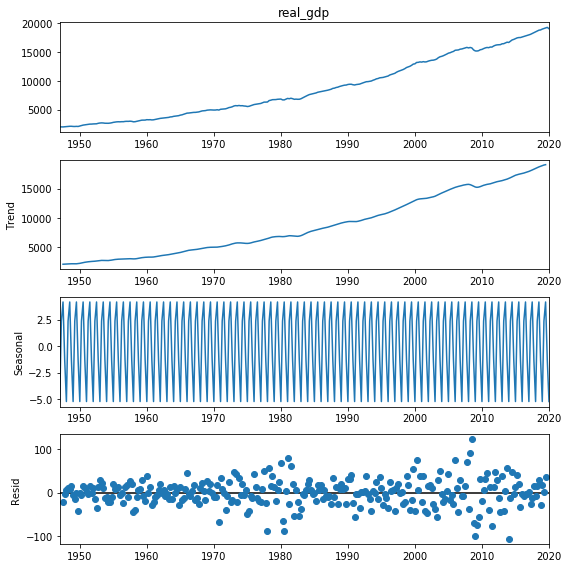

In [12]:
plt.rcParams.update({'figure.figsize': (8, 8)})
fig = res_add.plot()

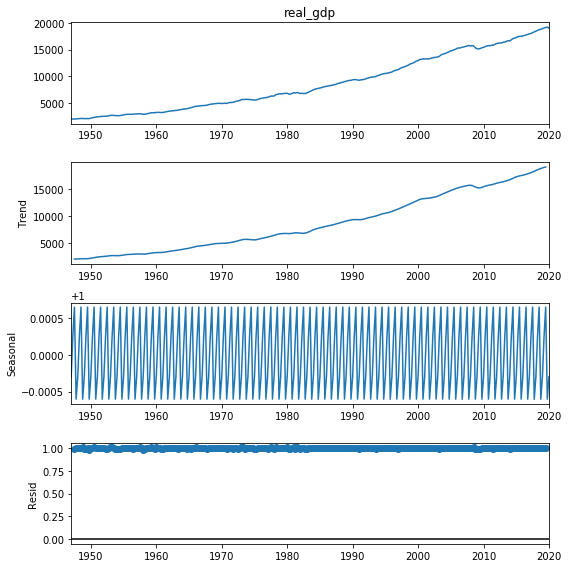

In [13]:
plt.rcParams.update({'figure.figsize': (8, 8)})
fig = res_mul.plot()

我们可以从seasonal_decompose函数返回的对象中提取seasonal, trend, error.

In [14]:
columns = ["trend", "seasonal", "resid", "observed"]

df_decompose = pd.concat([
    res_add.trend,  # 趋势
    res_add.seasonal,  # 季节性效应
    res_add.resid,  # 噪音
    res_add.observed  # 原始时间序列
], axis=1)

df_decompose.columns = columns

df_decompose.head(10)

,trend,seasonal,resid,observed
date,,,,
1947-01-01,NaN,-5.224925,NaN,2033.1
1947-04-01,NaN,2.371429,NaN,2027.6
1947-07-01,2041.4375,4.173039,-22.110539,2023.5
1947-10-01,2059.6625,-1.319543,-3.242957,2055.1
1948-01-01,2084.9125,-5.224925,6.312425,2086.0
1948-04-01,2108.5375,2.371429,9.591071,2120.5
1948-07-01,2120.9750,4.173039,7.451961,2132.6
1948-10-01,2120.6625,-1.319543,15.657043,2135.0
1949-01-01,2116.3250,-5.224925,-5.500075,2105.6


## 5. 平稳性

### 5.1 基础概念

#### 什么是平稳性？

平稳性(stationary): 时间序列的属性如均值，方差，自相关系数等不会随着时间发生变化。反之称为非平稳性。

#### 为什么关注平稳性？

很多预测模型都假设时间序列是平稳的，所以建模前要先检测是否平稳，如果不是要先转化为平稳序列。

以自回归预测模型为例，自回归用时间序列的过去值预测未来值，而回归模型假设预测因子相互独立，如果序列非平稳就无法满足假设，最终导致估计系数有偏差。

#### 如何将非平稳序列转化为平稳序列？

假设时间序列$Y_t$

1. 计算一阶差分：$\delta{Y} = Y_t - Y_{t-1}$
2. 取自然对数：$log(Y_t)$
3. 计算n次方根：$\sqrt[n]{Y_t}$
4. 混合使用以上三种方法

计算一阶差分是最常用的方法。

### 5.2 单位根检验

#### 什么是单位根(unit root)？

单位根是非平稳时间序列的一个特征，假设用以下方程描述时间序列$y_t$：

$$y_t = \gamma * y_{t-1} + \alpha * x_t + \epsilon_t$$

当$\gamma = 1$时，认为$y_t$有单位根，序列非平稳，本质上不可预测。

单位根检验是检测是否有单位根的统一理论，具体的检验方法有DF检验和ADF检验。

#### 什么是DF检验？

DF检验：具体的单位根检验方法，原假设为存在单位根，即下列回归方程$\gamma = 1$

$$y_t = \alpha + \beta * t + \gamma * y_{t-1} + \epsilon_t$$

两边同时减$y_{t-1}$，方程转化为：

$$\Delta{y_t} = \alpha + \beta * t + \lambda * y_{t-1} + \epsilon_t$$

其中$\lambda = \gamma - 1$，这是更常用的估计方程。如果$\lambda$显著异于零(即$\gamma$显著异于1)，拒绝原假设，认为时间序列平稳，反之不拒绝原假设，认为序列存在单位根，非平稳。

#### 什么是ADF检验？

ADF检验是DF检验的加强版，在回归模型中加入了$y_t$一阶差分的滞后项，如下列公式：

$$\Delta{y_t} = \alpha + \beta * t + \lambda * y_{t-1} + \sum_{i=1}^p \alpha_i * \Delta{y_{t-i}} + \epsilon_t$$

除此之外，ADF检验的原理，包括原假设，推断方法等和DF检验保持一致。

### 5.3 python实现ADF检验

statsmodel提供了实现ADF检验的函数：adfuller.

借助adfuller，可以获取检验统计量和p值。用户可以自定义滞后阶数，但更好的办法是让模型自动选择最优的滞后阶数，通过设置autolag='AIC'，函数会选择AIC最小的回归模型。

In [15]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series


def adf_test(ts: Series) -> None:
    """ADF检验，当p值低于选择的显著性水平如0.05，拒绝存在单位根的原假设，
    认为时间序列是平稳的，相反p值大于阈值认为序列非平稳
    """
    ts.dropna(inplace=True)
    res = adfuller(ts, autolag="AIC")
    print(f"ADF statistic: {res[0]:.3f}")
    print(f"p-value: {res[1]:.3f}")
    print(f"used lags: {res[2]}")

检验实际GDP原始值是否平稳。

In [16]:
adf_test(rgdp["real_gdp"])

ADF statistic: 2.216
p-value: 0.999
used lags: 2


p值几乎等于1，无法拒绝存在单位根的原假设，序列是非平稳的。

接下来测试实际GDP同比增长率是否平稳。

In [17]:
adf_test(rgdp["pc1"])

ADF statistic: -3.034
p-value: 0.032
used lags: 16


当选择显著性水平0.05，可以拒绝原假设，认为同比增长率是平稳的，但如果选择更严格的0.01，则无法拒绝原假设。

### 5.4 白噪音和平稳序列的区别是什么？

什么是白噪音(white noise)？

白噪音指随机时间序列，具有几个特点：零均值，有限方差和序列无关。白噪音可理解为随机冲击的集合，是不可预测的。白噪音理论上可以服从任何分布，如果假设服从正态分布，称为‘高斯白噪音’。

为什么研究白噪音？

在时间序列建模中，白噪音是一个很重要的概念，它经常出现在模型诊断的环节。

时间序列往往被认为是信号和白噪音的集合：$y_t = s_t + \epsilon_t$，其中$s_t$代表潜在信号，是可以被建模的部分，而$\epsilon_t$是白噪音，代表不可预测的随机冲击。如果预测模型的残差是白噪音，意味着模型捕捉了信号，相反如果残差部分仍然是有规律的，意味着模型有改善的空间。

Text(0.5, 1.0, 'white noise timeseries')

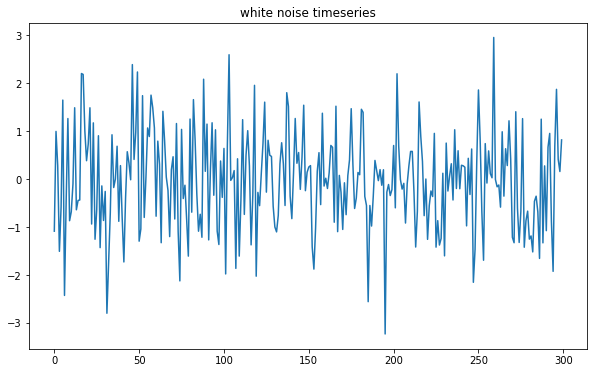

In [18]:
# 生成服从标准正态分布的随机变量
np.random.seed(123)
white_noise = np.random.normal(0, 1, 300)

# 白噪音具有以下特征：1. 均值为零，2. 有限方差；3. 均值和方差不会随着时间发生变化；4. 序列无关
# 通过简单的线图和自相关图可以大致判断时间序列是否为白噪音
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(white_noise)
ax.set_title("white noise timeseries")

Text(0.5, 1.0, 'auto-correlation for white noise timeseries')

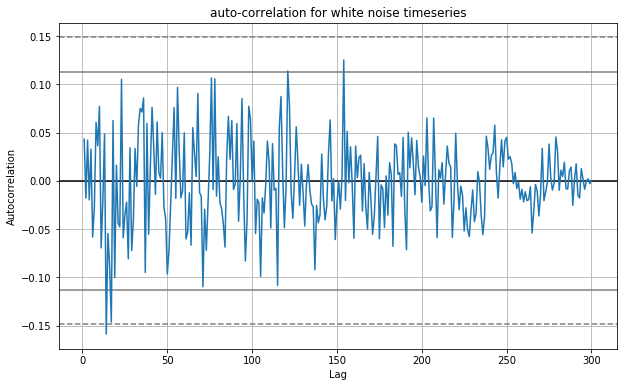

In [19]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10, 6))
autocorrelation_plot(white_noise, ax=ax)
ax.set_title("auto-correlation for white noise timeseries")

## 6. 识别季节性特征

如上文描述，时间序列可以被分解为几个部分，其中一个是季节性特征，它指的是时间序列在固定的时间段重复出现的模式。

固定时间段可以是：

1. 每天的某小时
2. 每周的某天
3. 每年的某一周
4. 每年的某个月
5. 每年的某个季度

如何识别季节性特征？

1. 线图，如果时间序列有明显的季节性特征，肉眼很容易识别。
2. 自相关系数，如果序列有显著的季节性特征，自相关系数会在相应的周期出现尖刺(spike)。

Text(0.5, 1.0, 'ACF to determine seasonality')

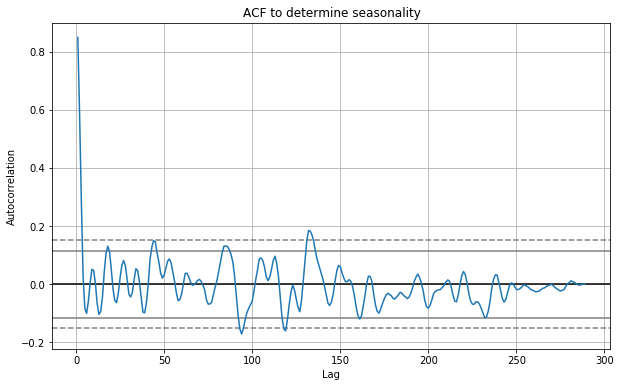

In [20]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10, 6))
autocorrelation_plot(rgdp["pc1"], ax=ax)
ax.set_title("ACF to determine seasonality")

## 7. 自相关和偏自相关

**自相关(autocorrelation)**：时间序列和滞后值的相关系数。如果序列显著自相关，可能有助于用过去值预测未来。

**偏自相关(partial autocorrelation)**：度量时间序列及其滞后值的相关性，但剔除了中间滞后值的影响。例如PACF(3)度量序列及其三阶滞后值的相关系数，但剔除了一阶滞后和二阶滞后值的影响。偏自相关可以理解为当期值和滞后K阶值的'纯'相关性。

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
# 计算滞后10阶的自相关系数
acf(rgdp["real_gdp"], nlags=10, fft=False)

array([1.        , 0.990265  , 0.98002054, 0.96971997, 0.95941187,
       0.9491038 , 0.9388738 , 0.9285773 , 0.91832545, 0.90813235,
       0.89793745])

In [23]:
# 计算滞后10阶的偏自相关系数
pacf(rgdp["real_gdp"], nlags=10)

array([ 1.00000000e+00,  9.93656321e-01, -4.71890275e-02, -9.81523567e-03,
       -7.35071657e-03, -7.05451453e-03, -8.51228136e-04, -1.30928892e-02,
       -3.24964070e-03, -2.79914751e-03, -7.91106339e-03])

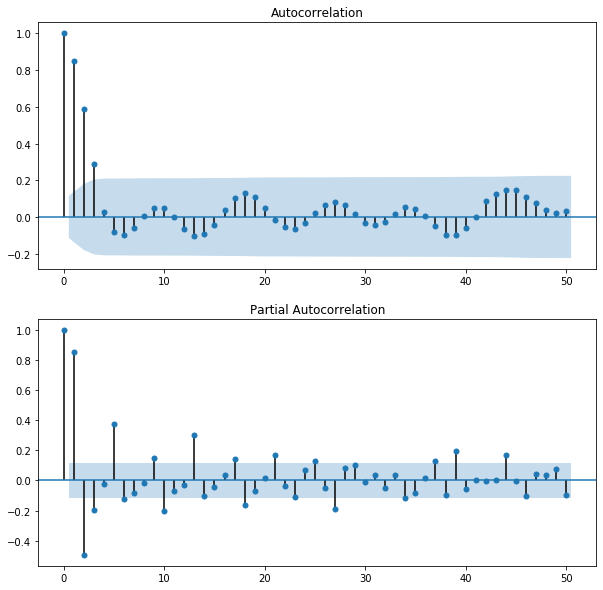

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax_0 = plot_acf(rgdp["pc1"], lags=50, ax=ax[0])
ax_1 = plot_pacf(rgdp["pc1"], lags=50, ax=ax[1])

## 8. 滞后图

滞后图(lag plots): 时间序列及其K阶滞后值的散点图，用于衡量是否自相关。

In [25]:
from pandas.plotting import lag_plot

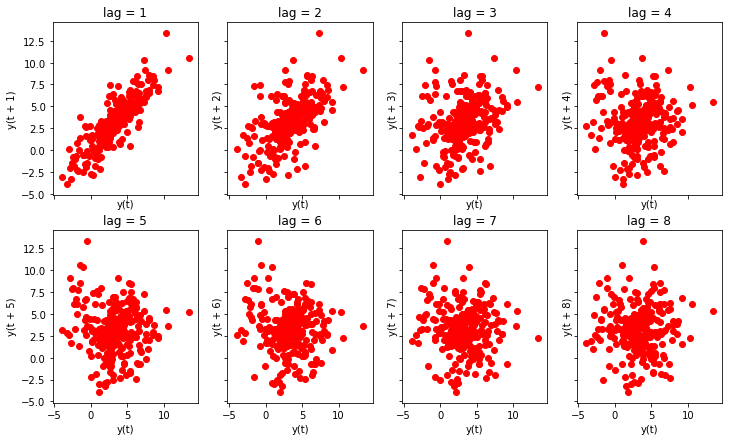

In [26]:
# 美国实际GDP增长率及其8阶滞后的滞后图
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 7), sharex=True, sharey=True)

for i,axi in enumerate(ax.flatten()):
    lag_plot(rgdp["pc1"], lag=(i + 1), ax=axi, c="red")
    axi.set_title(f"lag = {(i + 1)}")

## 9. 估计时间序列的可预测性

近似熵(Approximate Entropy)：量化时间序列的规律性和序列波动的不可预测性，近似熵的值越低，可重复的规律越明显，近似熵的值越大，序列越不可预测。

* [Wikipedia](https://en.wikipedia.org/wiki/Approximate_entropy)
* [近似熵理论和代码实现](https://blog.csdn.net/Cratial/article/details/79707169)

## 10. 移动平滑时间序列

为什么要移动平滑？

1. 移动平滑能剔除信号中的噪音。
2. 更好地呈现出潜在趋势。

如何实现移动平滑？

1. 计算移动平均线MA。
2. LOWESS(Locally Weighted Scatterplot Smoothing): 局部加权散点图平滑。给定时间序列，对于序列中的每一个点，使用附近的值对时间因子t回归，然后将点预测值作为该点的移动平滑。

statsmodels提供了实现[lowess平滑](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html)的接口。

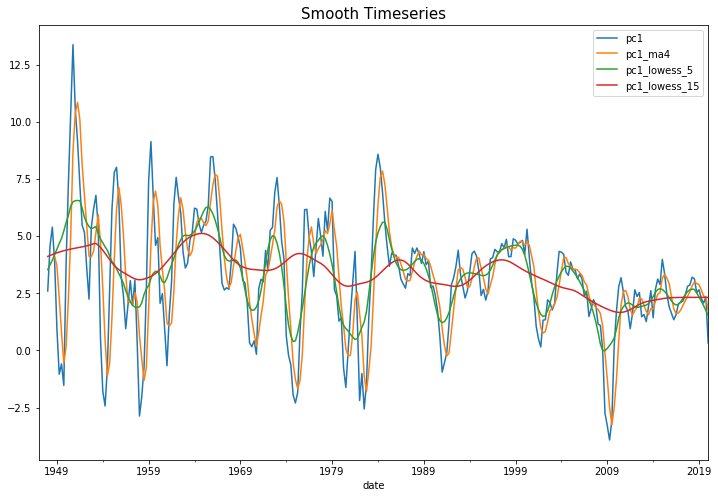

In [27]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# 实际GDP同比增长率的简单移动平均, window=4
rgdp["pc1_ma4"] = rgdp["pc1"].rolling(4).mean()

# lowess平滑
# frac参数控制参与局部回归的数值比例，frac取值在[0, 1]，数值越高，平滑程度越高，数值越低平滑度越低
rgdp["pc1_lowess_5"] = lowess(rgdp.pc1, np.arange(len(rgdp.pc1)), frac=0.05, return_sorted=False)
rgdp["pc1_lowess_15"] = lowess(rgdp.pc1, np.arange(len(rgdp.pc1)), frac=0.15, return_sorted=False)

# 可视化：对比几种平滑的结果
fig, ax = plt.subplots(figsize=(12, 8))
rgdp.plot(y="pc1", ax=ax)
rgdp.plot(y="pc1_ma4", ax=ax)
rgdp.plot(y="pc1_lowess_5", ax=ax)
rgdp.plot(y="pc1_lowess_15", ax=ax)
title = ax.set_title("Smooth Timeseries", fontsize=15)

## 11. 格兰杰因果检验

格兰杰因果检验(Granger causality test): 时间序列$X_t$能否用于预测另一个时间序列$Y_t$.

直觉理解：如果$X_t$是$Y_t$发生的"原因"，那么用$X_t$和$Y_t$的滞后值预测$Y_t$的效果要好于单独用$Y_t$的滞后值预测$Y_t$。

因果检验的原假设：$X_t$不是$Y_t$发生的原因。如果检验统计量低于临界值或p值小于显著性水平(0.05)，拒绝原假设，认为$X_t$的滞后值有助于预测$Y_t$.

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

In [29]:
# 简单测试：季度(分类变量)能否预测实际GDP同比增长率

# grangercausalitytests默认接受一个n*2数组，第一列是y(结果)，第二列是x(格兰杰原因)
# maxlag参数控制滞后阶数
x = rgdp[["pc1", "quarter"]].dropna()
results = grangercausalitytests(x, maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0470  , p=0.8286  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=0.0475  , p=0.8275  , df=1
likelihood ratio test: chi2=0.0475  , p=0.8275  , df=1
parameter F test:         F=0.0470  , p=0.8286  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0115  , p=0.9886  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=0.0234  , p=0.9884  , df=2
likelihood ratio test: chi2=0.0234  , p=0.9884  , df=2
parameter F test:         F=0.0115  , p=0.9886  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0081  , p=0.9990  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=0.0249  , p=0.9990  , df=3
likelihood ratio test: chi2=0.0249  , p=0.9990  , df=3
parameter F test:         F=0.0081  , p=0.9990  , df_denom=279, df_num=3
